# Emukit animation

In [1]:
# Convenient jupyter setup
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True

In [2]:
# set up plotting settings for dark mode.
from jupyterthemes import jtplot
jtplot.style(theme="grade3", context="notebook", ticks=True, grid=False)
from src.plot_utils import ps_defaults
ps_defaults(use_tex=False, dpi=150)

In [93]:
import os
import numpy as np
import matplotlib.pyplot as plt
import GPy
from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper
from emukit.experimental_design import ExperimentalDesignLoop
from emukit.core.initial_designs.latin_design import LatinDesign
from emukit.experimental_design.experimental_design_loop import ExperimentalDesignLoop
from emukit.model_wrappers import SimpleGaussianProcessModel
from emukit.core import ParameterSpace, ContinuousParameter
from emukit.experimental_design.acquisitions import ModelVariance
from src.plot_utils import label_subplots
from emukit.core.initial_designs.sobol_design import SobolDesign

In [94]:
os.mkdir("tmp_sobol")

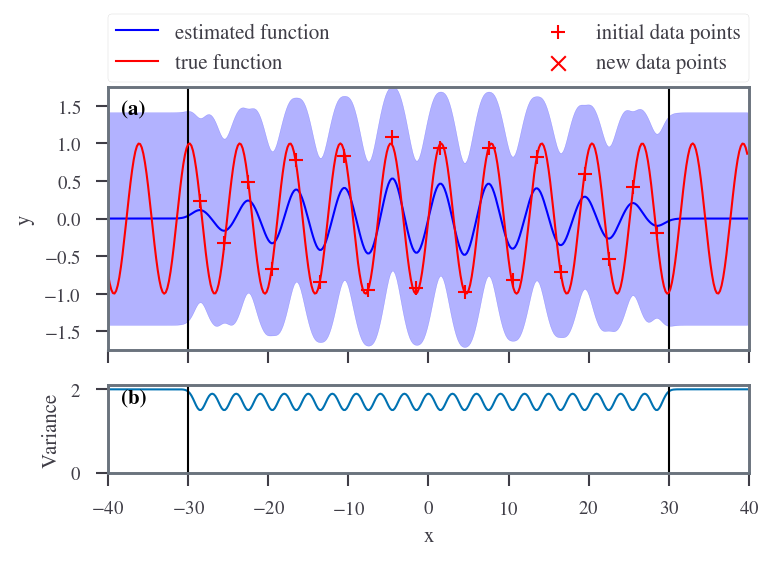

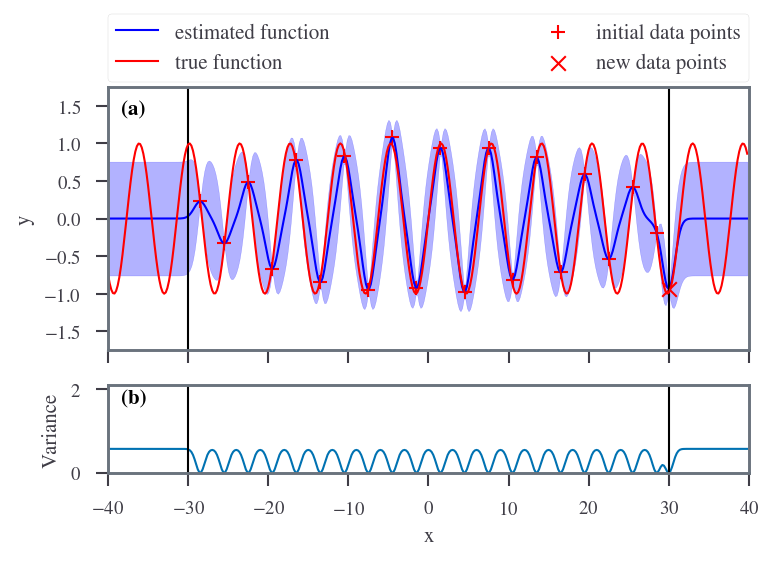

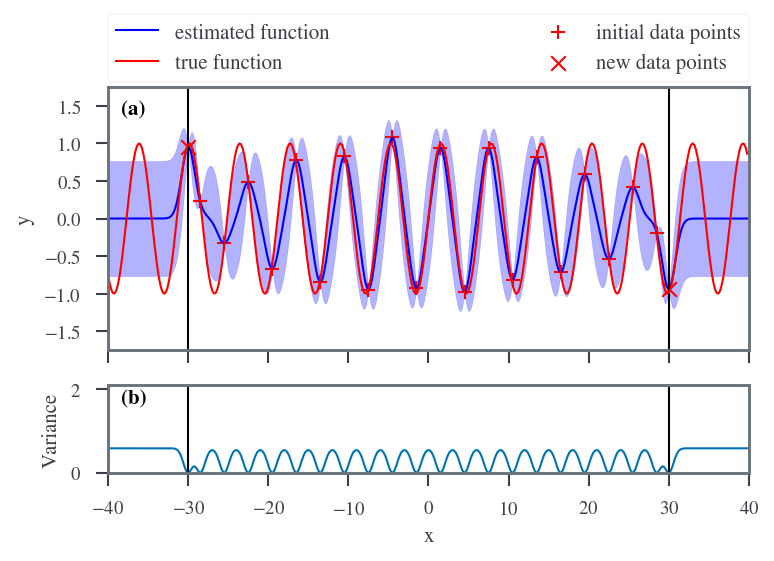

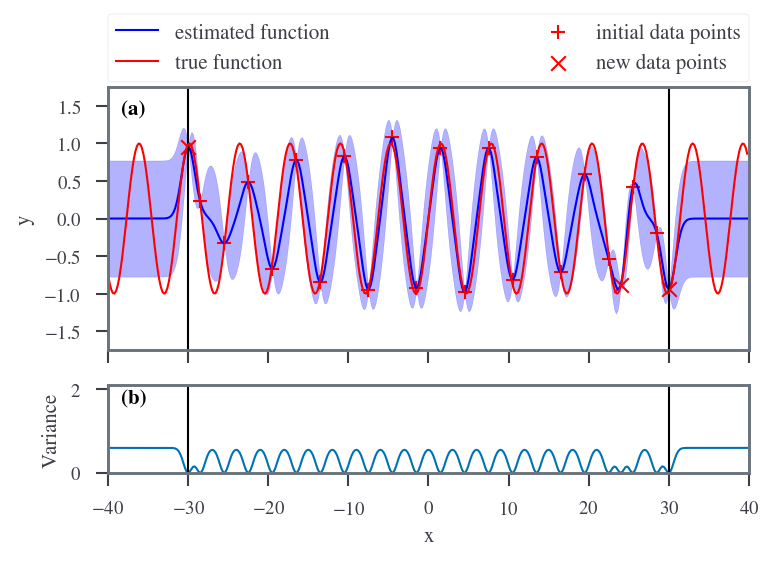

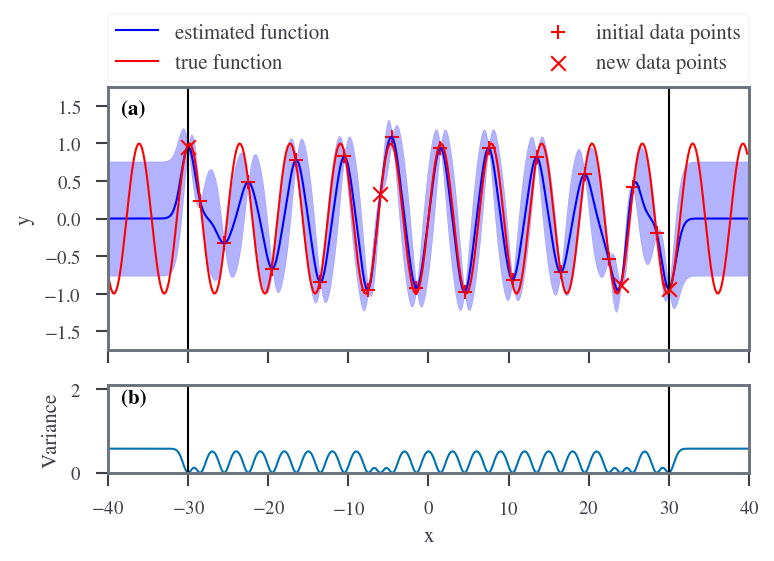

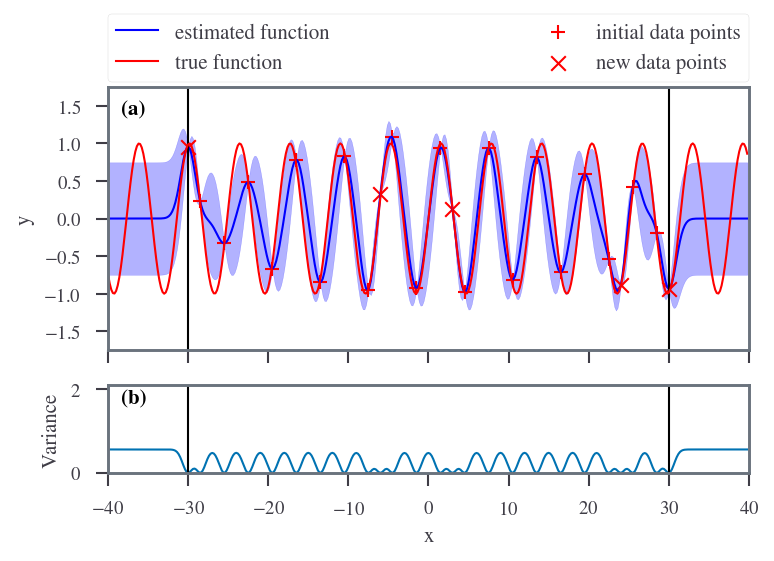

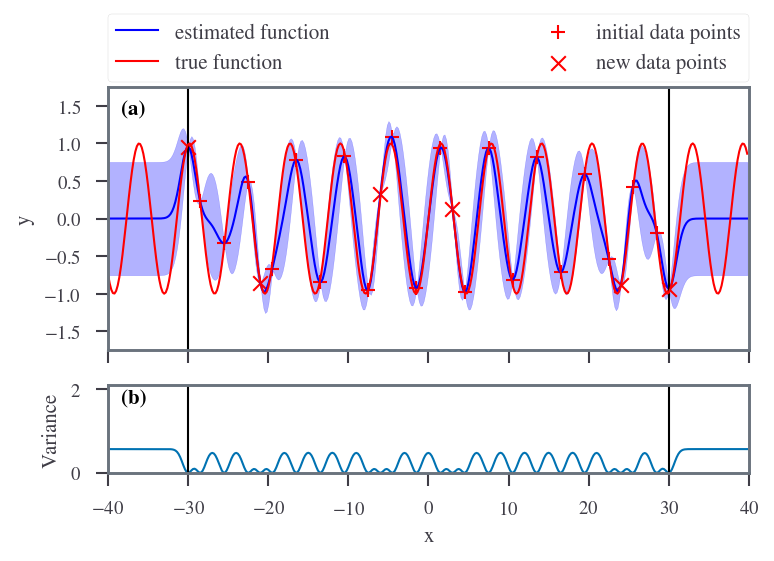

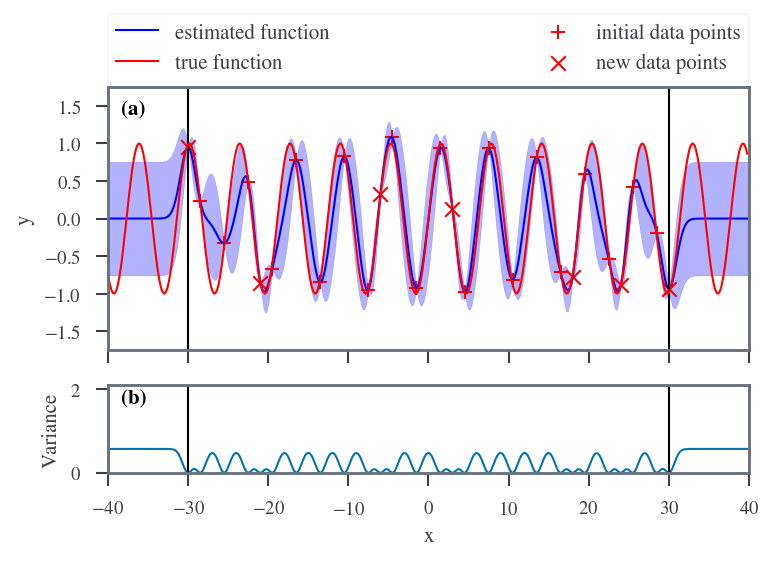

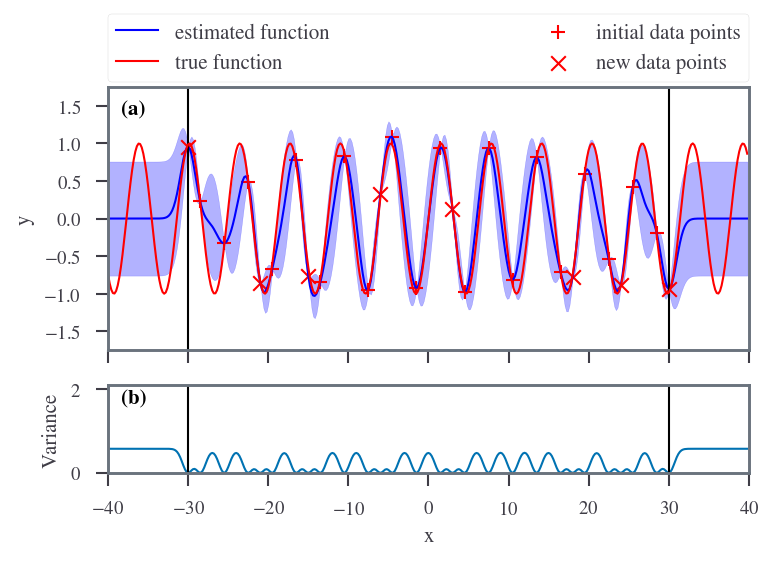

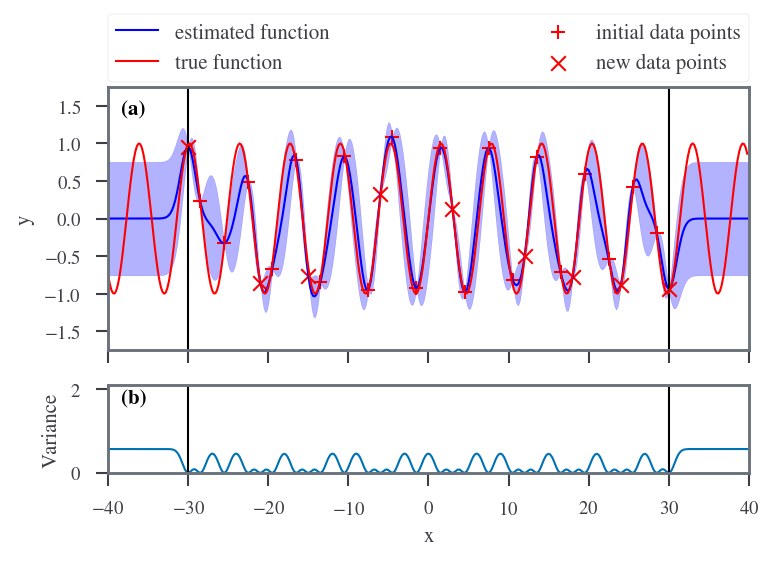

In [88]:
def func(x_inputs):
    return np.sin(x_inputs) + np.random.randn(len(x_inputs), 1) * 0.05

x_min = -30.0
x_max = 30.0
y_min = -1.75
y_max = -y_min
var_max = 2.1
var_min = 0

p = ContinuousParameter("c", x_min, x_max)
space = ParameterSpace([p])
design = LatinDesign(space)
num_init_data_points = 20
x_data = design.get_samples(num_init_data_points)
y_data = func(x_data)

model_gpy = GPRegression(x_data, y_data)
model_emukit = GPyModelWrapper(model_gpy)
model_variance = ModelVariance(model=model_emukit)
expdesign_loop = ExperimentalDesignLoop(
    model=model_emukit, space=space, acquisition=model_variance, batch_size=1
)

for i in range(10):
    plot_min = -40.0
    plot_max = 40.0
    real_x = np.arange(plot_min, plot_max, 0.2)
    real_y = np.sin(real_x)

    predicted_y = []
    predicted_std = []
    for x in real_x:
        y, var = model_emukit.predict(np.array([[x]]))
        std = np.sqrt(var)
        predicted_y.append(y)
        predicted_std.append(std)

    predicted_y = np.array(predicted_y).flatten()
    predicted_std = np.array(predicted_std).flatten()

    fig, (ax0, ax1) = plt.subplots(
        2, 1, gridspec_kw={"height_ratios": [3, 1]}, sharex=True
    )

    ax0.plot(real_x, predicted_y, label="estimated function", color="blue")
    ax0.fill_between(
        real_x,
        predicted_y - predicted_std,
        predicted_y + predicted_std,
        color="blue",
        alpha=0.3,
    )
    ax0.scatter(x_data, y_data, c="red", marker="+", label="initial data points")
    ax0.scatter(
        expdesign_loop.loop_state.X[len(x_data) :],
        expdesign_loop.loop_state.Y[len(x_data) :],
        c="red",
        label="new data points",
    )
    ax0.plot([x_min, x_min], [y_min, y_max], color="black")
    ax0.plot([x_max, x_max], [y_min, y_max], color="black")
    ax0.set_xlim([plot_min, plot_max])
    ax0.set_ylabel("y")
    ax0.plot(real_x, real_y, label="true function", color="red")
    ax0.set_ylim([y_min, y_max])
    ax0.legend(
        bbox_to_anchor=(0, 1.02, 1, 0.2),
        loc="lower left",
        mode="expand",
        borderaxespad=0,
        ncol=2,
    )
    var = model_variance.evaluate(real_x.reshape(len(real_x), 1))
    ax1.plot(real_x, var)
    ax1.set_ylabel("Variance")
    ax1.plot([x_min, x_min], [var_min, var_max], color="black")
    ax1.plot([x_max, x_max], [var_min, var_max], color="black")
    ax1.set_xlabel("x")
    ax1.set_ylim([var_min, var_max])
    label_subplots([ax0, ax1])
    plt.savefig("tmp/" + str(i) + ".png", bbox_inches="tight")
    plt.show()
    expdesign_loop.run_loop(func, 1)

In [91]:
import imageio as io
import os

file_names = sorted(("tmp/" + fn for fn in os.listdir("tmp")))
with io.get_writer("gifs/max-var.gif", mode="I", duration=0.5) as writer:
    for filename in file_names:
        image = io.imread(filename)
        writer.append_data(image)
writer.close()

In [1]:
def func(x_inputs):
    return np.sin(x_inputs) + np.random.randn(len(x_inputs), 1) * 0.05

x_min = -30.0
x_max = 30.0
y_min = -1.75
y_max = -y_min
var_max = 2.1
var_min = 0

p = ContinuousParameter("c", x_min, x_max)
space = ParameterSpace([p])
design = SobolDesign(space)
num_init_data_points = 20
x_data = design.get_samples(num_init_data_points)
y_data = func(x_data)

model_gpy = GPRegression(x_data, y_data)
model_gpy.optimize()
model_emukit = GPyModelWrapper(model_gpy)
model_variance = ModelVariance(model=model_emukit)
expdesign_loop = ExperimentalDesignLoop(
    model=model_emukit, space=space, acquisition=model_variance, batch_size=1
)

for i in range(10):
    plot_min = -40.0
    plot_max = 40.0
    real_x = np.arange(plot_min, plot_max, 0.2)
    real_y = np.sin(real_x)

    predicted_y = []
    predicted_std = []
    for x in real_x:
        y, var = model_emukit.predict(np.array([[x]]))
        std = np.sqrt(var)
        predicted_y.append(y)
        predicted_std.append(std)

    predicted_y = np.array(predicted_y).flatten()
    predicted_std = np.array(predicted_std).flatten()

    fig, (ax0, ax1) = plt.subplots(
        2, 1, gridspec_kw={"height_ratios": [3, 1]}, sharex=True
    )

    ax0.plot(real_x, predicted_y, label="estimated function", color="blue")
    ax0.fill_between(
        real_x,
        predicted_y - predicted_std,
        predicted_y + predicted_std,
        color="blue",
        alpha=0.3,
    )
    ax0.scatter(x_data, y_data, c="red", marker="+", label="initial data points")
    ax0.scatter(
        expdesign_loop.loop_state.X[len(x_data) :],
        expdesign_loop.loop_state.Y[len(x_data) :],
        c="red",
        label="new data points",
    )
    ax0.plot([x_min, x_min], [y_min, y_max], color="black")
    ax0.plot([x_max, x_max], [y_min, y_max], color="black")
    ax0.set_xlim([plot_min, plot_max])
    ax0.set_ylabel("y")
    ax0.plot(real_x, real_y, label="true function", color="red")
    ax0.set_ylim([y_min, y_max])
    ax0.legend(
        bbox_to_anchor=(0, 1.02, 1, 0.2),
        loc="lower left",
        mode="expand",
        borderaxespad=0,
        ncol=2,
    )
    var = model_variance.evaluate(real_x.reshape(len(real_x), 1))
    ax1.plot(real_x, var)
    ax1.set_ylabel("Variance")
    ax1.plot([x_min, x_min], [var_min, var_max], color="black")
    ax1.plot([x_max, x_max], [var_min, var_max], color="black")
    ax1.set_xlabel("x")
    ax1.set_ylim([var_min, var_max])
    label_subplots([ax0, ax1])
    plt.savefig("tmp_sobol/" + str(i) + ".png", bbox_inches="tight")
    plt.show()
    expdesign_loop.run_loop(func, 1)

NameError: name 'ContinuousParameter' is not defined

In [96]:
import imageio as io
import os

file_names = sorted(("tmp_sobol/" + fn for fn in os.listdir("tmp_sobol")))
with io.get_writer("gifs/sobol-min-var.gif", mode="I", duration=0.5) as writer:
    for filename in file_names:
        image = io.imread(filename)
        writer.append_data(image)
writer.close()

In [102]:
from gpy import GPy.kern.RBF

SyntaxError: invalid syntax (4073080824.py, line 1)

In [113]:
GPRegression(x_data, y_data, kernel=GPy.kern.src.stationary.Cosine(1))

GP_regression.,value,constraints,priors
Cosine.variance,1.0,+ve,
Cosine.lengthscale,1.0,+ve,
Gaussian_noise.variance,1.0,+ve,


In [108]:
GPy.kern.RBF?

In [112]:
GPy.kern.src.stationary.Cosine(1)